# 1. Dataset Loading and Environment Setup

In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [ ]:
!gdown 18d8LMm61ddRcHLvbncBJjxkA4LijFT-k
!gdown 1dY2Rvck-rsmyuqrciHLsteRurfptK9De
!gdown 1DI9mDSCfOZUc6FIwSdIo7KQPXmz3tYAb

Downloading...
From: https://drive.google.com/uc?id=18d8LMm61ddRcHLvbncBJjxkA4LijFT-k
To: /content/train.csv
100% 6.25M/6.25M [00:00<00:00, 265MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dY2Rvck-rsmyuqrciHLsteRurfptK9De
To: /content/dev.csv
100% 816k/816k [00:00<00:00, 134MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DI9mDSCfOZUc6FIwSdIo7KQPXmz3tYAb
To: /content/test.csv
100% 777k/777k [00:00<00:00, 107MB/s]


In [ ]:
%%capture
!pip install datasets
!pip install transformers
!pip install --upgrade accelerate
!pip install evaluate
!pip install datsets transformers[sentencepiece]
!pip install sentencepiece
!pip install rouge-score
!pip install bert_score
!pip install optuna

In [ ]:
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from rouge_score import rouge_scorer
from datasets import load_metric
from evaluate import load
import optuna

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_id = 0 if str(device) == 'cuda' else -1

In [ ]:
train_df = pd.read_csv('train.csv')
dev_df = pd.read_csv('dev.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
model_name = 'google/pegasus-large'

In [ ]:
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 2. Data Analysis
We want to see the distribution of review token lengths and summary token lengths to decide the max length to impose on our model

In [ ]:
# Lists to store token lengths
review_lengths = []
summary_lengths = []
reviews = train_df['reviewText']
summaries = train_df['summary']
# Calculate token lengths for reviews
for review in reviews:
    tokenized_review = tokenizer.encode(review)
    review_lengths.append(len(tokenized_review))

# Calculate token lengths for summaries
for summary in summaries:
    tokenized_summary = tokenizer.encode(summary)
    summary_lengths.append(len(tokenized_summary))

Token indices sequence length is longer than the specified maximum sequence length for this model (1188 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
pd.Series(review_lengths).describe()

count    11095.000000
mean       101.780171
std        166.105280
min          2.000000
25%         27.000000
50%         50.000000
75%        111.000000
max       5301.000000
dtype: float64

In [ ]:
pd.Series(summary_lengths).describe()

count    11095.000000
mean         7.697792
std          4.354841
min          2.000000
25%          5.000000
50%          7.000000
75%         10.000000
max         51.000000
dtype: float64

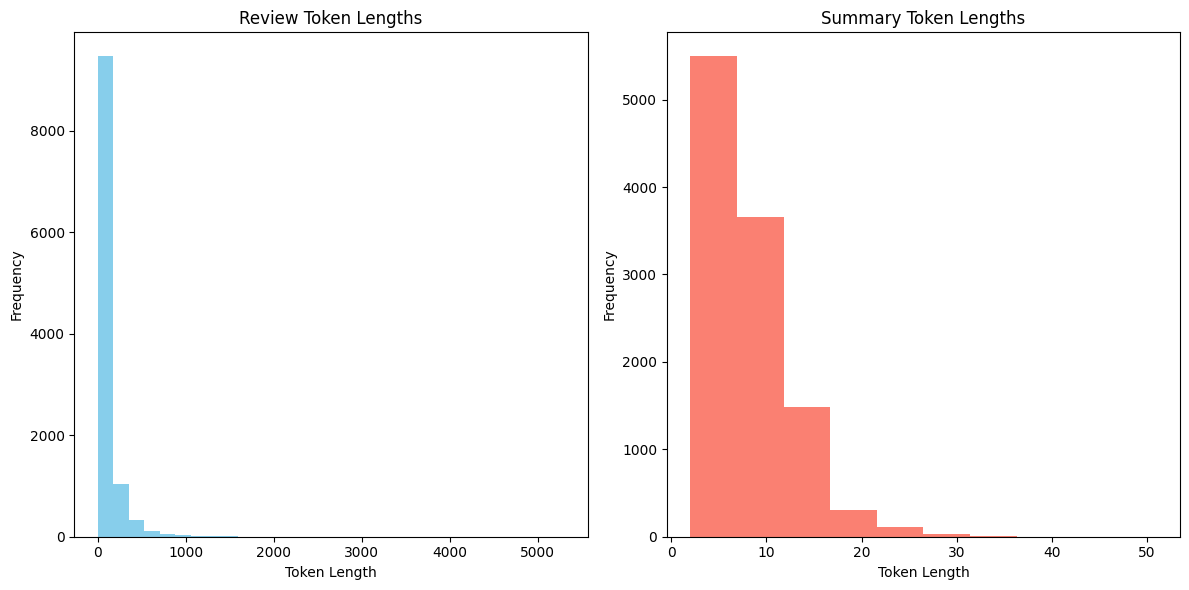

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot distribution of review token lengths
axs[0].hist(review_lengths, bins=30, color='skyblue')
axs[0].set_title('Review Token Lengths')
axs[0].set_xlabel('Token Length')
axs[0].set_ylabel('Frequency')

# Plot distribution of summary token lengths
axs[1].hist(summary_lengths, bins=10, color='salmon')
axs[1].set_title('Summary Token Lengths')
axs[1].set_xlabel('Token Length')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 3. Creating a Custom Dataset

In [ ]:
class SummarizationDataset(Dataset):
    def __init__(self, input_ids, target_ids):
        self.input_ids = input_ids
        self.target_ids = target_ids

    def __len__(self):
        return len(self.input_ids['input_ids'])

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids['input_ids'][idx],
            'attention_mask': self.input_ids['attention_mask'][idx],
            'labels': self.target_ids['input_ids'][idx],
        }

Since most reviews are under 256 tokens, we will set that as our maximum review length and truncate the rest of the review. Since most of the summary lengths are under 32 tokens, we will set the maximum review length to be 32

In [ ]:
MAX_INPUT_LEN = 256
MAX_OUTPUT_LEN = 32

In [ ]:
def make_summarization_dataset(df):
  input_ids = tokenizer(df['reviewText'].tolist(), return_tensors='pt', max_length=MAX_INPUT_LEN, truncation=True, padding=True)
  target_ids = tokenizer(df['summary'].tolist(), return_tensors='pt', max_length=MAX_OUTPUT_LEN, truncation=True, padding=True)
  return SummarizationDataset(input_ids, target_ids)

In [ ]:
train_dataset = make_summarization_dataset(train_df)
eval_dataset = make_summarization_dataset(dev_df)
test_dataset = make_summarization_dataset(test_df)

In [ ]:
print(len(train_dataset))
print(len(eval_dataset))
print(len(test_dataset))

11095
1387
1388


# 4. Model

## 4.1 Hyperparameter Tuning
To speed up the tuning process, we will only tune on 10% of the original training set

In [ ]:
from torch.utils.data import Subset
import random

In [ ]:
random.seed(42)
tuning_size = int(len(train_dataset) * 0.1)
tuning_indices = random.sample(range(len(train_dataset)), tuning_size)
tuning_dataset = Subset(train_dataset, tuning_indices)

In [ ]:
def objective(trial):
    return {
        "learning_rate": trial.suggest_categorical("learning_rate",[1e-5, 1e-4, 1e-3]),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16]),
    }

In [ ]:
trainer_args = TrainingArguments(
    evaluation_strategy='epoch',
    logging_strategy="epoch",
    output_dir='pegasus-training',
    optim="adafactor",
    num_train_epochs=2,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
)

In [ ]:
def model_init(trial):
    return PegasusForConditionalGeneration.from_pretrained(model_name)

In [ ]:
trainer = Trainer(model=None,
                  args=trainer_args,
                  tokenizer=tokenizer,
                  train_dataset=tuning_dataset,
                  eval_dataset=eval_dataset,
                  model_init=model_init)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
best_trial = trainer.hyperparameter_search(
    direction="minimize",
    backend="optuna",
    hp_space=objective,
    n_trials=9
)

[I 2023-12-22 03:42:38,065] A new study created in memory with name: no-name-d8eab015-b300-468c-8ccc-80f704bed090
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,2.882700,0.804588
1,0.524300,0.808805


[I 2023-12-22 03:46:24,626] Trial 0 finished with value: 0.8088053464889526 and parameters: {'learning_rate': 0.001, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.8088053464889526.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,10.897200,9.680423
1,9.781700,9.401194


[I 2023-12-22 03:50:10,759] Trial 1 finished with value: 9.401193618774414 and parameters: {'learning_rate': 1e-05, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.8088053464889526.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,8.776000,6.939942
1,6.324900,4.721288


[I 2023-12-22 03:53:58,118] Trial 2 finished with value: 4.721287727355957 and parameters: {'learning_rate': 0.0001, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.8088053464889526.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,4.731800,0.815104
1,0.614900,0.787942


[I 2023-12-22 03:56:32,681] Trial 3 finished with value: 0.7879420518875122 and parameters: {'learning_rate': 0.001, 'per_device_train_batch_size': 8}. Best is trial 3 with value: 0.7879420518875122.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,8.123000,3.199726
1,1.711400,0.844154


[I 2023-12-22 03:58:51,104] Trial 4 finished with value: 0.844153881072998 and parameters: {'learning_rate': 0.001, 'per_device_train_batch_size': 16}. Best is trial 3 with value: 0.7879420518875122.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,11.463900,10.202345


[I 2023-12-22 04:00:15,180] Trial 5 pruned. 
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,4.731800,0.815104
1,0.614900,0.787942


[I 2023-12-22 04:02:52,642] Trial 6 finished with value: 0.7879420518875122 and parameters: {'learning_rate': 0.001, 'per_device_train_batch_size': 8}. Best is trial 3 with value: 0.7879420518875122.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,10.206100,8.789196


[I 2023-12-22 04:04:08,934] Trial 7 pruned. 
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,10.897200,9.680423


[I 2023-12-22 04:06:10,999] Trial 8 pruned. 


In [ ]:
best_trial

BestRun(run_id='3', objective=0.7879420518875122, hyperparameters={'learning_rate': 0.001, 'per_device_train_batch_size': 8}, run_summary=None)

## 4.2 Model Training

In [ ]:
BATCH_SIZE = 8
EPOCHS=2
LEARNING_RATE = 1e-3

In [ ]:
torch.cuda.empty_cache()

In [ ]:
trainer_args = TrainingArguments(
    evaluation_strategy='steps',
    logging_strategy="steps",
    output_dir='pegasus-training',
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    load_best_model_at_end=True,
    save_strategy = "steps",
    logging_steps=100
)

trainer = Trainer(model=model,
                  args=trainer_args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
100,2.090900,0.811138
200,0.770300,0.798151
300,0.760900,0.776859
400,0.640500,0.790585
500,0.544000,0.788998
600,0.515200,0.783342


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=692, training_loss=0.8385747181886882, metrics={'train_runtime': 1129.8391, 'train_samples_per_second': 19.64, 'train_steps_per_second': 0.612, 'total_flos': 1.5995352630951936e+16, 'train_loss': 0.8385747181886882, 'epoch': 2.0})

In [ ]:
torch.cuda.empty_cache()

In [ ]:
steps = np.arange(100, 601, 100)
eval_loss = [trainer.state.log_history[1 + i * 2]['eval_loss'] for i in range(0, len(steps))]
train_loss = [trainer.state.log_history[i * 2]['loss'] for i in range(0, len(steps))]

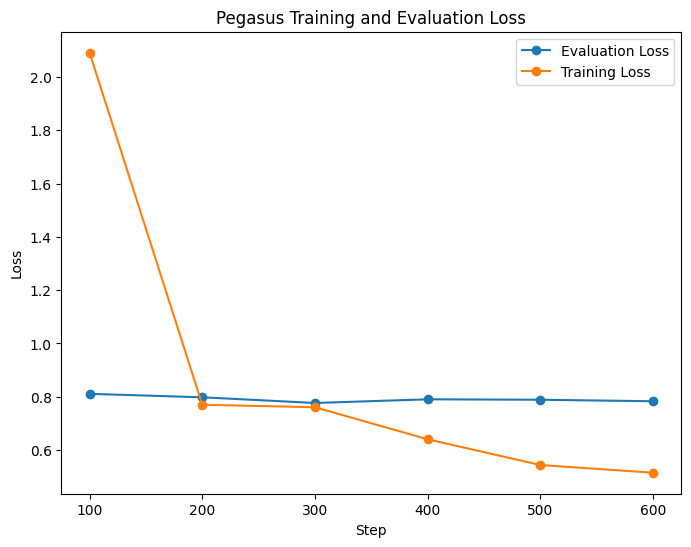

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(steps, eval_loss, label='Evaluation Loss', marker='o')
plt.plot(steps, train_loss, label='Training Loss', marker='o')
plt.title('Pegasus Training and Evaluation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.xticks(steps)
plt.show()

As we can see above, the model begins overfitting after 300 steps. This is approximately 1 epoch on our dataset. We will thus retrain the model for only 1 epoch

In [ ]:
trainer_args = TrainingArguments(
    evaluation_strategy='steps',
    logging_strategy="steps",
    output_dir='pegasus-training',
    optim="adafactor",
    num_train_epochs=1,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    weight_decay=0.1,
    load_best_model_at_end=True,
    save_strategy = "steps",
    logging_steps=100
)

trainer = Trainer(model=model,
                  args=trainer_args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset)

In [ ]:
trainer.train()
trainer.save_model('./pegasus_model')

Step,Training Loss,Validation Loss
100,2.149300,0.804339
200,0.747900,0.771129
300,0.730800,0.750014


# 5. Evaluation

## 5.1 Generate Results
We first generate the results of our model for each of our datasets

In [ ]:
model = PegasusForConditionalGeneration.from_pretrained('/content/pegasus_model')
model = model.to(device)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
dev_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
NUM_BEAMS = 8
LENGTH_PENALTY = 0.8
def generate_summary(dataloader):
  summaries = []
  for batch in dataloader:
    input_ids = batch['input_ids']
    attention_masks = batch['attention_mask']
    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)

    encoded_summaries = model.generate(
          input_ids=input_ids,
          attention_mask=attention_masks,
          max_length=MAX_OUTPUT_LEN,
          num_beams=NUM_BEAMS,
          length_penalty=LENGTH_PENALTY,
          early_stopping=True
      )
    decoded_summaries = tokenizer.batch_decode(encoded_summaries, skip_special_tokens=True)
    summaries.extend(decoded_summaries)
  return summaries

In [ ]:
train_predictions = generate_summary(train_loader)
dev_predictions = generate_summary(dev_loader)
test_predictions = generate_summary(test_loader)

In [ ]:
train_references = train_df['summary']
dev_references = dev_df['summary']
test_references = test_df['summary']

## 5.2 Evaluation Metrics
We will use both rouge_score and bert_score for our evaluation metrics. We will specifically be looking at the averaged f1 scores of both metrics.

In [ ]:
def rouge_score(prediction, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(prediction, reference)
    return scores

In [ ]:
def evaluate_rouge(predictions, references):
  rouge1_f = 0
  rouge2_f = 0
  rougeL_f = 0

  num_reviews = len(predictions)
  for pred, actual in zip(predictions, references):
    scores = rouge_score(pred, actual)
    rouge1_f += scores['rouge1'][2]
    rouge2_f += scores['rouge2'][2]
    rougeL_f += scores['rougeL'][2]

  rouge1_f = rouge1_f / num_reviews
  rouge2_f = rouge2_f / num_reviews
  rougeL_f = rougeL_f / num_reviews

  return (rouge1_f, rouge2_f, rougeL_f)

In [ ]:
bertscore = load("bertscore")
def evaluate_bert(predictions, references):
  results = bertscore.compute(predictions=predictions,
                              references=references,
                              rescale_with_baseline=True,
                              lang='en')
  f1_scores = results['f1']
  if len(f1_scores) == 0:
    return None

  return sum(f1_scores) / len(f1_scores)


## 5.3 Evaluate Results

In [ ]:
torch.cuda.empty_cache()

In [ ]:
print("Training Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate_rouge(train_predictions, train_references)
bert_f = evaluate_bert(train_predictions, train_references)
print("ROUGE-1 F-Score: ", rouge1_f)
print("ROUGE-2 F-Score: ", rouge2_f)
print("ROUGE-L F-Score: ", rougeL_f)
print("Bert F-Score: ", bert_f)
print("-------------")
print("Dev Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate_rouge(dev_predictions, dev_references)
bert_f = evaluate_bert(dev_predictions, dev_references)
print("ROUGE-1 F-Score: ", rouge1_f)
print("ROUGE-2 F-Score: ", rouge2_f)
print("ROUGE-L F-Score: ", rougeL_f)
print("Bert F-Score: ", bert_f)
print("-------------")
print("Test Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate_rouge(test_predictions, test_references)
bert_f = evaluate_bert(test_predictions, test_references)
print("ROUGE-1 F-Score: ", rouge1_f)
print("ROUGE-2 F-Score: ", rouge2_f)
print("ROUGE-L F-Score: ", rougeL_f)
print("Bert F-Score: ", bert_f)

Training Eval


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1 F-Score:  0.2292236219837195
ROUGE-2 F-Score:  0.13443812607765612
ROUGE-L F-Score:  0.22405570293601665
Bert F-Score:  0.19108245752023942
-------------
Dev Eval
ROUGE-1 F-Score:  0.20990573162683304
ROUGE-2 F-Score:  0.11113168674157384
ROUGE-L F-Score:  0.2055436483372813
Bert F-Score:  0.17019194622582984
-------------
Test Eval
ROUGE-1 F-Score:  0.20699745891393112
ROUGE-2 F-Score:  0.11184235747476227
ROUGE-L F-Score:  0.20015582949333266
Bert F-Score:  0.16801354934914842


# 6. Save Results

In [ ]:
def write_to_file(data, file_name):
    with open(file_name, 'w') as txtfile:
        for row in data:
            txtfile.write(str(row) + '\n')

In [ ]:
write_to_file(dev_predictions, 'pegasus_dev_pred.txt')
write_to_file(dev_references, 'pegasus_dev_ref.txt')

In [ ]:
write_to_file(test_predictions, 'pegasus_test_pred.txt')
write_to_file(test_references, 'pegasus_test_ref.txt')

In [ ]:
write_to_file(train_predictions, 'pegasus_train_pred.txt')
write_to_file(train_references, 'pegasus_train_ref.txt')